### Решение задачи бинарной классификации кошек и собак с дообучением MobileNetV2.<br> Dataset: https://huggingface.co/datasets/microsoft/cats_vs_dogs/

## 0. Imports

In [2]:
import pandas as pd
import io
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras import layers, models
from datasets import load_dataset
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

### 1. Dataset upload

In [3]:
df_part_1 = pd.read_parquet('data/train-00000-of-00002.parquet')
df_part_2 = pd.read_parquet('data/train-00001-of-00002.parquet')
df = pd.concat([df_part_1[0:3000], df_part_2[0:3000]], ignore_index=True)
print(df.shape)
df.head()

(6000, 2)


,image,labels
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


## 2. Подготовка данных 

* Извлечение байтов: Получили байты изображения из словаря, хранящегося в колонке DataFrame.

* Декодирование и изменение размера: С помощью библиотеки Pillow байты были преобразованы в объект изображения, а затем изменён размер всех изображений до 64x64 пикселей для унификации.

* Нормализация: Значения пикселей (от 0 до 255) были разделены на 255, чтобы привести их к диапазону от 0 до 1. Это стандартная практика, которая помогает модели обучаться более эффективно.

In [4]:
IMG_SIZE = (128, 128)

def process_image(image_bytes):
    try:
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        image = image.resize(IMG_SIZE)
        return np.array(image, dtype=np.float32) / 255.0
    except (IOError, ValueError, TypeError) as e:
        print(f"Ошибка при обработке изображения: {e}")
        return None

processed_data = []
for index, row in df.iterrows():
    img_bytes = row['image'].get('bytes')
    processed_img = process_image(img_bytes)
    if processed_img is not None:
        processed_data.append({'image': processed_img, 'label': row['labels']})

df_processed = pd.DataFrame(processed_data)

images = np.stack(df_processed['image'].values)
labels = df_processed['label'].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (4800, 128, 128, 3)
Размер тестовой выборки: (1200, 128, 128, 3)


## 3. Моделирование CNN

### Построил простую, но эффективную CNN, которая состоит из следующих слоёв:

* Свёрточные слои (Conv2D): Три слоя с ядрами 3x3, которые извлекают признаки из изображений. Первый слой имеет 32 фильтра, а последующие — 64. Активационная функция ReLU используется для введения нелинейности.

* Слои пулинга (MaxPooling2D): Три слоя пулинга 2x2, которые уменьшают пространственный размер карты признаков, делая модель более устойчивой к небольшим сдвигам в изображениях и сокращая количество вычислений.

* Выравнивание (Flatten): После свёрточных слоёв данные выравниваются в одномерный вектор.

* Полносвязные слои (Dense):

    * Первый Dense слой с 64 нейронами и активацией ReLU обрабатывает одномерный вектор.

    * Финальный Dense слой с одним нейроном и активацией sigmoid для бинарной классификации. Этот слой выдаёт вероятность принадлежности изображения кклассу "собака".

In [19]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 233ms/step - accuracy: 0.8681 - loss: 0.3006 - val_accuracy: 0.9592 - val_loss: 0.1186
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - accuracy: 0.9450 - loss: 0.1427 - val_accuracy: 0.9625 - val_loss: 0.0988
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.9533 - loss: 0.1182 - val_accuracy: 0.9617 - val_loss: 0.0933
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 194ms/step - accuracy: 0.9592 - loss: 0.1041 - val_accuracy: 0.9642 - val_loss: 0.0898
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - accuracy: 0.9685 - loss: 0.0923 - val_accuracy: 0.9617 - val_loss: 0.0871


In [21]:
some_image_tensor = X_test[500:501]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


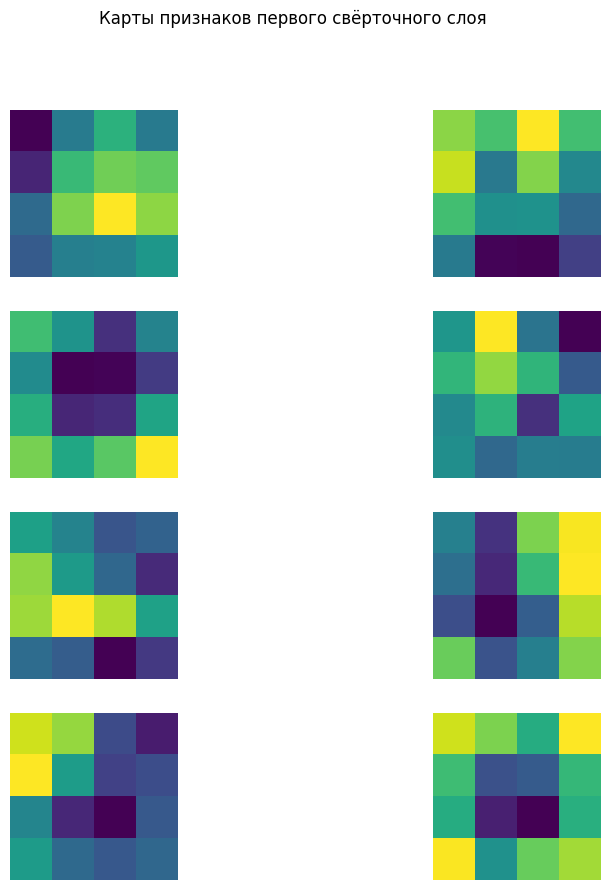

In [22]:
activation_model = Model(inputs=model.input, outputs=model.get_layer('Conv_1').output)

activations = activation_model.predict(some_image_tensor)

plt.figure(figsize=(10, 10))
for i in range(8):
    plt.subplot(4, 2, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Карты признаков первого свёрточного слоя')
plt.show()

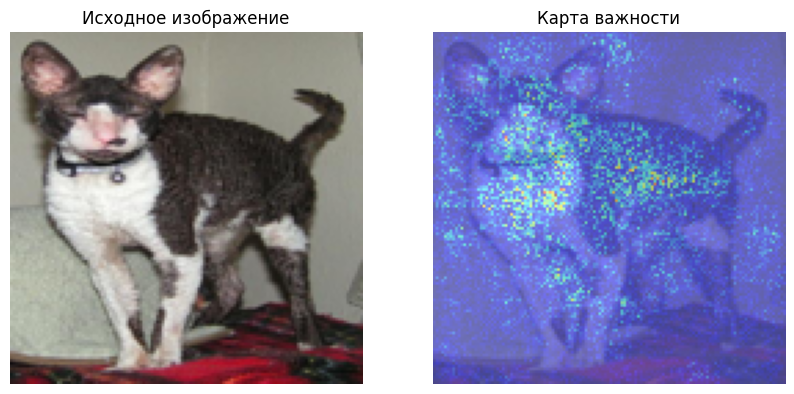

In [23]:
def make_saliency_map(img_array, model):
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, img_tensor)

    saliency = tf.abs(grads)
    saliency = tf.reduce_max(saliency, axis=-1)

    return saliency.numpy()[0]

saliency_map = make_saliency_map(some_image_tensor, model)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(some_image_tensor[0])
plt.title("Исходное изображение")
plt.axis('off')

plt.subplot(1, 2, 2)
saliency_map = saliency_map / np.max(saliency_map)
plt.imshow(some_image_tensor[0], alpha=0.5)
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.title("Карта важности")
plt.axis('off')

plt.show()

### 4. Оценка

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nТочность на тестовой выборке: {test_acc}")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

38/38 - 6s - 151ms/step - accuracy: 0.9617 - loss: 0.0871

Точность на тестовой выборке: 0.9616666436195374
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step


In [25]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))

print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       621
           1       0.96      0.96      0.96       579

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200


Матрица ошибок:
[[597  24]
 [ 22 557]]


### Результаты показывают, что дообученная модель MobileNetV2 достигла очень высокой точности и эффективности в классификации кошек и собак. Она демонстрирует значительно лучшие результаты по сравнению с нашей первой CNN-моделью и классическими алгоритмами, что подтверждает высокую эффективность дообучения для решения подобных задач на небольших наборах данных.